## **Business Understanding**

This project aims to effectively analyze and predict arrest outcomes of Terry Stops that have been conducted by the Seattle Police Department. It mainly focuses on whether a stop will result in a formal arrest or not. By leveraging features such as the time of day, precinct location, subject demographics and the presence of weapons, the model seeks to uncover the key drivers behind police decision-making for any given traffic stop. This will not only provide law enforcement agencies with insights into operational patterns and resource allocation, but also offer stakeholders and policymakers a data-driven lens to evaluate the consistency, transparency and factors that influence police interventions.

## **Data Understanding**

The [dataset](Data/Terry_Stops_20251229.csv) consists of 65,931 records and 23 features that comprehensively represent Terry Stops reported by the Seattle Police Department. Each row represents a unique police stop incident.

Key Features: The features can be categorized into four main groups:

 * **Subject Demographics**: Attributes describing the individual(s) who have been stopped by an officer and they include but not limited to: `Subject Age Group`, `Subject Perceived Race` and `Subject Perceived Gender`.

 * **Officer Demographics**: These are attributes describing the officer involved; such as `Officer ID`, `Officer Gender`, `Officer Race` and `Officer Year of Birth`.

 * **Event Details**: Contextual information about the stop, including `Reported Date`, `Occurred Date`, `Precinct`, `Sector` and `Beat`.

* **Operational Factors**: Police procedure details, such as `Initial Call Type`, `Final Call Type`, `Frisk Flag` (whether a frisk was performed) and `Weapon Type`.  


<br>

The target variable will be `Arrest Flag`, which is a binary indicator showing whether the stop resulted in a physical arrest (Y) or not (N). The varaible is thus significant and valuable for our classification task at hand.

<br>
The distribution of the dataset is highly imbalanced. This is because:

  * No Arrest (N): ~89% of cases (58,368 stops)

  * Arrest (Y): ~11% of cases (7,563 stops)

The model must account for this imbalance to prevent it from simply predicting "No Arrest" every time to achieve high accuracy.

<br>
In terms of the data quality, the following were some of the notable observations:

 1. **Missing Values**: The `Weapon Type` column contains a significant number of missing values (~50%), often indicating that no weapon was involved.

 2. **Placeholder Values**: Several columns contain placeholder characters like `-` or `Unknown`, which require cleaning during the preprocessing stage.

 3. **Categorical Complexity**: Features like `Call Type` and `Final Call Type` have high cardinality (many unique text values), requiring grouping or dimensionality reduction for effective modeling.

4. **Subject ID Issues**: A large number of records have a Subject ID of -1, indicating that many subjects were not uniquely identified or linked to a master record system.

In [ ]:
# Importing the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [61]:
# Loading the dataset
df_raw = pd.read_csv('Data/Terry_Stops_20251229.csv')
df_raw

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat,Occurred Date
0,1 - 17,-1,20170000317010,301638,Arrest,None,7773,1978,Male,White,...,OBS - FIGHT - IP - PHYSICAL (NO WEAPONS),"ASSAULTS, OTHER",911,NORTH PCT 3RD W - B/N RELIEF,N,N,North,L,L3,2017-08-27T03:18:00
1,26 - 35,7752588737,20240000337534,61254189481,Offense Report,-,8584,1982,Male,White,...,BURG - COMM BURGLARY,WARRANT SERVICES - MISDEMEANOR,ONVIEW,SOUTH PCT 1ST W - SAM - PLATOON 2,N,N,South,O,O1,2024-11-30T05:20:00
2,56 and Above,-1,20190000057245,532414,Arrest,None,8606,1965,Female,White,...,ASLT - WITH OR W/O WPNS (NO SHOOTINGS),"ASSAULTS, OTHER",911,TRAINING - FIELD TRAINING SQUAD,N,N,West,M,M3,2019-02-15T13:15:00
3,26 - 35,-1,20180000002293,434590,Field Contact,None,8022,1990,Male,Hispanic,...,-,-,-,TRAINING - FIELD TRAINING SQUAD,N,N,-,-,-,2018-06-24T18:49:00
4,36 - 45,7727706299,20250000063255,63109655222,Field Contact,-,8974,1997,Female,White,...,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,NORTH PCT 2ND W - BOY (JOHN) - PLATOON 1,N,N,North,U,U2,2025-03-08T17:58:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65926,26 - 35,24073393003,20210000161230,25788659982,Field Contact,-,8639,1995,Male,White,...,SUICIDE - CRITICAL,CRISIS COMPLAINT - GENERAL,911,WEST PCT 3RD W - QUEEN - PLATOON 1,N,Y,West,D,D3,2021-06-28T00:50:00
65927,46 - 55,-1,20160000002680,167703,Field Contact,None,6910,1979,Female,White,...,-,-,-,NORTH PCT 3RD W - NORA (JOHN) - PLATOON 1,N,N,-,-,-,2016-06-25T03:08:00
65928,26 - 35,-1,20180000004277,506414,Field Contact,None,8365,1984,Female,White,...,-,-,-,WEST PCT 3RD W - MARY - PLATOON 1,N,N,-,-,-,2018-11-23T22:38:00
65929,26 - 35,12068334192,20200000145237,13106277523,Field Contact,-,6355,1970,Female,White,...,OBS - BURG - IP/JO - COMM BURG (INCLUDES SCHOOLS),SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,911,EAST PCT 1ST W - E/G RELIEF (CHARLIE),N,N,East,C,C1,2020-05-02T05:53:00


### **Exploratory Data Analysis**

1. **Data Quality Check**

The [Dataset](Data/Terry_Stops_20251229.csv) contains a total of 65,931 stops records and 23 columns with no duplicate entries within the entire dataset.

However, there were notable instances of missing data such as: 

 * Weapon Type: ~50% missing (32,565 rows). This likely implies "No Weapon" or "Not Recorded".

 * Officer Squad: A small number (566) are missing.


Imbalance: The target variable `Arrest Flag` is highly imbalanced with about 88.5% of stops resulting in no arrest ('N') while 11.5% resulted in an arrest ('Y').


2. **Univariate Analysis**

Subject Demographics:

Age: The most frequently stopped age group is 26-35, followed by 36-45 and 18-25.

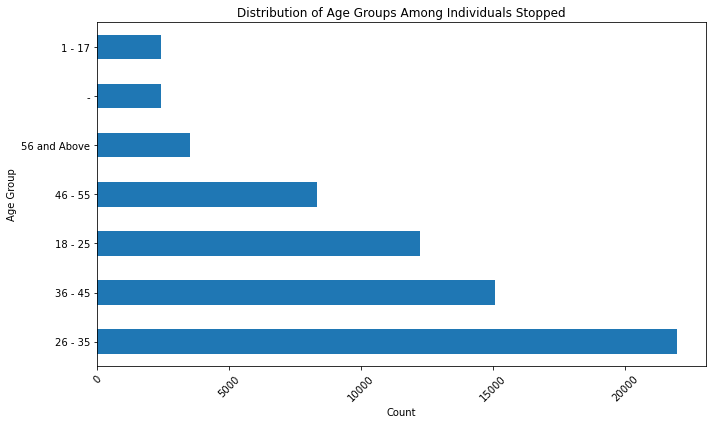

In [62]:
# A bar chart showing the distribution of age groups among the individuals stopped.
plt.figure(figsize=(10,6))
df_raw['Subject Age Group'].value_counts().plot(kind='barh')
plt.title('Distribution of Age Groups Among Individuals Stopped')
plt.xlabel('Count')
plt.ylabel('Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Race: The majority of subjects are perceived as White or Black or African American. There is a significant drop-off for other racial groups.

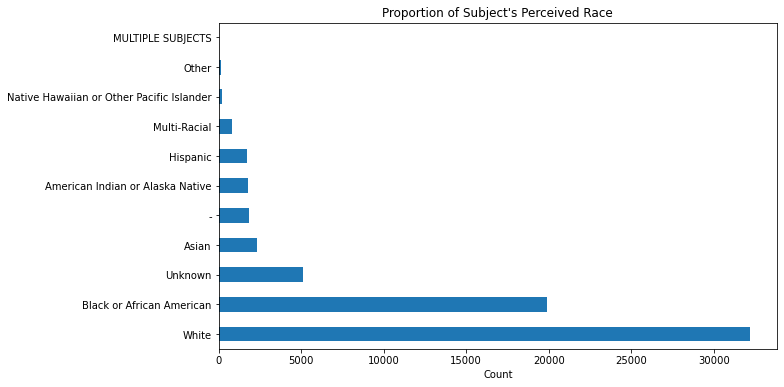

In [63]:
# A bar chart illustrating the proportion of subject's perceived race
plt.figure(figsize=(10, 6))
df_raw['Subject Perceived Race'].value_counts().plot(kind='barh')
plt.title('Proportion of Subject\'s Perceived Race')
plt.xlabel('Count')
plt.ylabel('')
plt.show()

Stop Outcomes:

Resolution: The most common resolution is "Field Contact", followed by "Offense Report" and "Arrest". This confirms that most Terry Stops do not lead to an immediate booking.

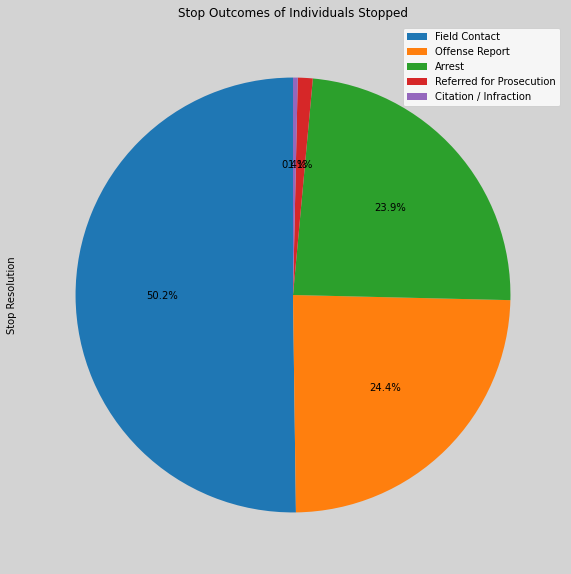

In [64]:
# A piechart chart showing the stop outcomes of the individuals stopped
plt.figure(figsize=(10, 10), facecolor = 'lightgrey')
df_raw['Stop Resolution'].value_counts().plot(kind='pie', labels = None, autopct='%1.1f%%', startangle=90)
plt.title('Stop Outcomes of Individuals Stopped')
plt.legend(labels=df_raw['Stop Resolution'].value_counts().index, loc="best")
plt.show()

3. **Key Relationships (Bivariate Analysis)**

Arrest Rates by Race:

This chart visualizes the proportion of stops that turn into arrests for each racial group. It allows you to check for potential disparities in outcomes once a stop has been initiated.


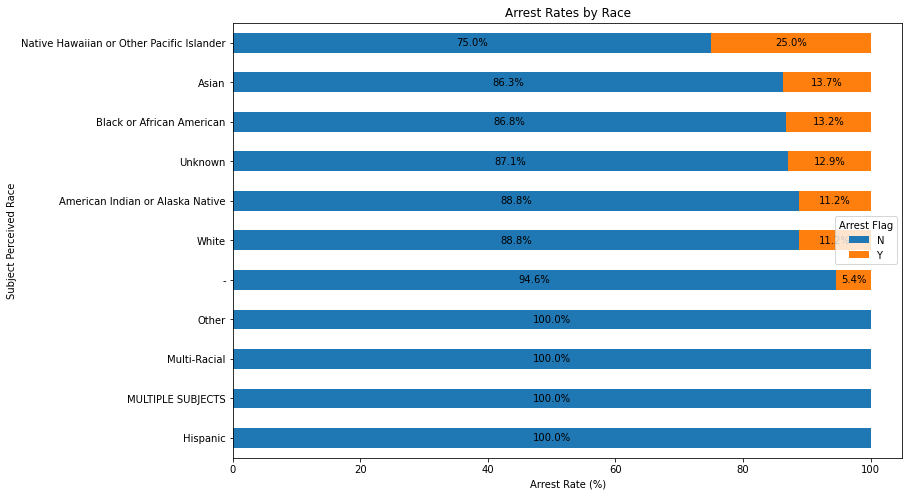

In [66]:
# A bar chart showing the Arrest rates by Race
race_arrest = pd.crosstab(df_raw['Subject Perceived Race'], df_raw['Arrest Flag'], normalize='index') * 100

# Sorting the indexes for better visualization
if 'Y' in race_arrest.columns:
    race_arrest = race_arrest.sort_values(by='Y', ascending=True)

plot = race_arrest.plot(kind='barh', figsize=(12, 8), stacked=True)
plt.title('Arrest Rates by Race')
plt.ylabel('Subject Perceived Race')
plt.xlabel('Arrest Rate (%)')
plt.legend(title='Arrest Flag', loc='center right')

# Adding percentages to the bar chart
for bar in plot.patches:
    width = bar.get_width()
    if width > 5:  # Only show label if segment is large enough
        plt.text(bar.get_x() + width/2, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', ha='center', va='center')
plt.show()

